# Lecture 11 Speech Recognition
## Speech Analysis

* [Learning Objectives](#goal)
   * [Sound into numbers](#sound_to_waves)
* [Visualization of the recordings - input features](#visualization)
   * [ Wave and spectrogram](#waveandspectrogram)
   * [ MFCC](#mfcc)
   * [ Silence removal](#resampl)
   * [ Resampling - dimensionality reductions](#silenceremoval)
   * [ Features extraction steps](#featuresextractionsteps)
* [Dataset investigation](#investigations)
   * [Number of files](#numberoffiles)
   * [Mean spectrograms and fft](#meanspectrogramsandfft)
   * [Deeper into recordings](#deeper)
   * [Length of recordings](#len)
   * [Note on Gaussian Mixtures modeling](#gmms)
   * [Frequency components across the words](#components)
   * [Anomaly detection](#anomaly)
* [Where to look for inspiration](#wheretostart)

## Learning Objectives <a id="goal"></a> 
Towards the end of the lecture we wil build a Simple Speech Recognition Engine using Convolutional Layers in Keras which will classified different sounds. 
<br>- We will learn how to perform feature extraction (MFCC) and train the model
<br>- We will demonstrate that our model can recognize words.
<br>- Determine different words captured by the microphone (Test)   

We learned about CNNs, RNNs and classified MNIST for images dataset using Deep Learning libraries. We learned how to take an image and treat it as an array of numbers so that we can feed directly into a neural network for image recognition. Now we can do the same with speech recognition audio files! 
<br> 
### Sound is transmitted as waves. How do we turn sound waves into numbers? <a id="sound_to_waves"></a>
Speech recognition is complex and tricky so to keep everything simple we will start with a practical tutorial using word recognition and Kaggle datasets of number words. 
<br>

### Data and Code
<br>Data used in the examples in this notebook are downloaded from https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz site. The directory into which we expanded collections of single spoken words: bird, dog, cat, four, happy,..., etc, we called `data`.
       <br> To reduce the processing time, we trained the neural network using a subset of data. You can do as you please. You can work with small or the entire data set. 
        <br>Static images in this notebook should resided in directory named `images`. The content of the directory `images` is provide on the class site, week 12 folder.
<br> 
<br>Code used in the examples below is borrowed from: https://blog.manash.me/building-a-dead-simple-word-recognition-engine-using-convnet-in-keras-25e72c19c12b 

<br>Speech recordings are broken up into little chunks of phonetic signals of typical duration of 25 msec. Those windows are overlapping and slide (typically) 10 msec at a time.
<br>The distinguishable units of speech are called phoneme.
<br>Phoneme units are grouped into words
<br>Spoken words are a sequence of sound waves<br>
<br>We will create vectors from the audio signal in order to feed our deep learning model. We work with RNN (LSTM)s to processes sequences. 
<br>In the follwing examples we will actually use convolutional neural networks for the classification of speech samples.
<br>Inputs will be tensors of features representing speech utterances.
![train-words.png](images/train-words.png)

We will perform classification using audio files with small words such as "seven", "happy", "yes", others

### How to embed the audio into vector space? 
There are many techniques and some Python packages solely for extraction of audio features. 
<br>MFCC encoding (Mel Frequency Cepstral Coefficients) is a very effective technique for encoding of speech signals. That technique was used for classicla non-nural network speech recognition.
<br>

# Various libraries we might or might not use

In [1]:
!pip install librosa
!pip install plotly

In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fft import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline


## Audio Processing - Turning Sounds into Bits<a id="audio"></a> 
The first step in any automatic speech recognition system is to extract features i.e. identify the components of the audio signal that are good for identifying the linguistic content and discarding all the other stuff which carries information like background noise, emotion etc. 
<br>
The main point to understand about speech is that the sounds generated by a human are filtered by the shape of the vocal tract including tongue, teeth etc. This shape determines what sound comes out. If we can determine the shape accurately, this should give us an accurate representation of the phoneme being produced. The shape of the vocal tract manifests itself in the envelope of the short time power spectrum, and the job of MFCCs is to accurately represent this envelope.
<br>
## Speech Signals - Sound Waves & Digital Sampling<a id="signals"></a>
Think of Sound waves as one-dimensional. At every moment in time, they have a single value based on the height of the wave. To turn this sound wave into numbers, we just record of the height of the wave at equally-spaced points. This is called sampling.
![digitalsample.png](images/digitalsample.png)
We are taking a reading thousands of times a second and recording a number representing the height of the sound wave at that point in time. That’s basically all an uncompressed .wav audio file is. “CD Quality” audio is sampled at 44.1khz (44,100 readings per second). But for speech recognition, a sampling rate of 16khz (16,000 samples per second) is enough to cover the frequency range of human speech.

**Pitch** is a perceptual property of sounds that allows their ordering on a frequency-related scale, or more commonly, pitch is the quality that makes it possible to judge sounds as "higher" and "lower" in the sense associated with musical melodies. 

In musics, **an octave** is the distance between one note (like C#) and the next note bearing its same name (the next C# that's either higher or lower). In physics, an octave is the distance between one note and another note that's double its frequency.

#### Pre-processing the Sampled Sound Data and what is a MFCC?
From Niquist theorem's we know that we could perfectly reconstruct the original sound wave from the sample readings — as long as we sample at least twice as fast as the highest frequency we want to record.

Nearly everyone gets this wrong and assumes that using higher sampling rates always leads to better audio quality. It doesn’t.

The most commonly used feature extraction method in automatic speech recognition (ASR) is Mel-Frequency Cepstral Coefficients (MFCC).<br> <b> MFCC are useful featurs, vectors or numerical encoding of sound waves we need for deep learning models! </b> <br>Mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of speech, based on a linear cosine transform of a log power spectrum on a nonlinear Mel scale of frequency.
<br> Mel-frequency scale is described by the following formula expressing `mels` over `frequency`:
![mels_vs_frequency.png](images/mels_vs_frequency.png)

<br> The mel scale, introduced by Stevens, Volkmann, and Newman in 1937, is a perceptual scale of pitch judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments. As a result, four octaves on the hertz scale above 500 Hz are judged to comprise about two octaves on the mel scale. The name mel comes from the word melody to indicate that the scale is based on pitch perception.
![mel_frequency_scale.png](images/mel_frequency_scale.png)
<br>Guided by the Mel frequency scale, we conclude that in order to capture speach it is necessary to take many samples at low frequencies but fewer and fewer at higher frequencies. 
<br>This is reflected in the design of the banks of filters which are used for speech recording. Typical recording software (hardware) operates as if it captures sounds through a set of filters with progressively larger and larger band-width.
![filter_bank.png](images/filter_bank.png)




MFCC vectors are feature vector containing "all" information about the sound waves representing human words. MFCC mimics some parts of the human speech production and speech perception. MFCC mimics the logarithmic perception of loudness and the logarithmic perception of pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. To represent the dynamic nature of speech, the MFCC representation also includes the change of the feature vectors over time.

# Visualizing Sound 
<a id="visualization"></a> 

There used to be two theories of a human hearing - Place Theory ( https://en.wikipedia.org/wiki/Place_theory_(hearing) (frequency-based) and Temporal theory (https://en.wikipedia.org/wiki/Temporal_theory_(hearing) )
In speech recognition, some people use as input [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) (frequencies). 
Others use more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients. 
We rarely work with raw, temporal data.

Let's visualize some recordings!

### Wave and spectrogram:
Choose and read some file:

In [3]:
audio_path = 'data/'
filename = 'yes/0a7c2a8d_nohash_0.wav'
#filename = '/seven/6c968bd9_nohash_0.wav'
# sample_rate, samples = wavfile.read(str(audio_path) + filename)
samples, sample_rate = librosa.load(str(audio_path)+filename)

In [4]:
print(samples.shape)
print("sample rate: ", sample_rate)

(22050,)
sample rate:  22050


### Function that calculates spectrogram, `log_specgram()`

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.

In [5]:
#def log_specgram(audio, sample_rate, window_size=20,
#                 step_size=10, eps=1e-10):
def log_specgram(audio, sample_rate=16000, window_size=20,
                 step_size=10, eps=1e-10):
    if audio.ndim > 1 : #ignore channels  2+
        audio = audio[:,0]
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3)) 
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
#return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Frequencies in human speech are in the range 0 to 8000Hz. According to [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_rate),  we could faithfully reproduce speech signal from digital file created with sampling rate of 16,000/sec

Let's plot some spectrograms:

Text(0.5, 0, 'Seconds')

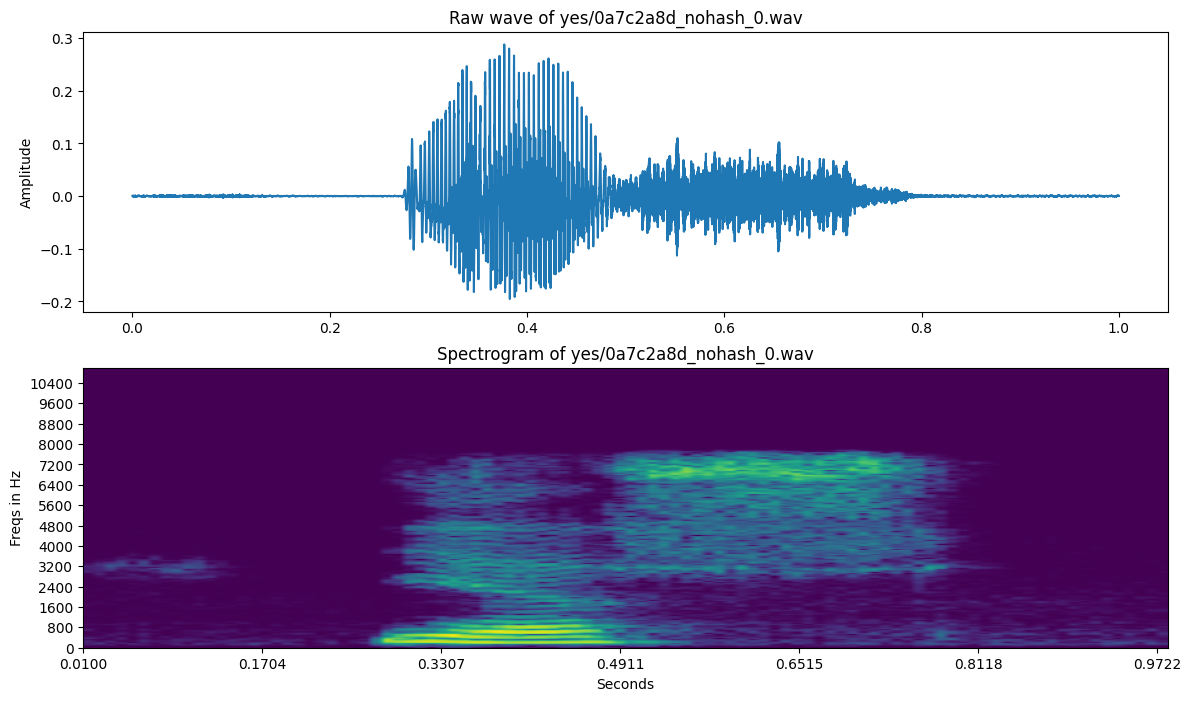

In [6]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

We will sse the spectrograms as input features for our Neural Networks. This means that we need to normalize all spectra in the dataset. We would use functions in the follwoing cell, but not just for one spectrum, but for all spectra in the training, validation and test dataset. 

In [7]:
# Do not run this code
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

There is an interesting fact to point out. 

If a frame is long 20 mseconda and we recorded 16000 signals per second, we have 320 measurements (features) in each frame. Frequencies of recorded speech are between 0 and 8000. It means, that one measurement (feature)  corresponds to 25 Hz. Between 1000 and 2000 Hz, frequency resolution of human ear is 3.6 Hz. That means, that ears are more precise and can hear much smaller details than those represented by spectrograms like above.

### Librosa, Pyhton Sound Processing Library¶
It appears that `librosa` is the most popular sound processing library. To have Librosa work properly on Windows, you need to have package `ffmpeg` installed and its `ffmpeg/bin` directory placed in the `PATH` environmental variable. 

In [8]:
# To load audio files and resample a signal at 16000Hz, you would use command like:
#librosa.load(audio_path, sr=16000) 
# To load files without resampling, do:
#librosa.load(audio_path, sr=None)

### Fourier Transformation & Mel-Frequency Spectrum
<b>Fourier Transform:</b>
![fourier.gif](images/fourier.gif)
<div class="alert alert-block alert-success"> 
The first processing step is the computation of the frequency domain representation of the input signal. This is achieved by computing the <b> Discrete Fourier Transform.</b>
<br>
Where N is the number of sampling points within a speech frame and the time frame τ. The Fast Fourier Transform (FFT), is a very efficient variation of the Discrete Fourier Transformation optimized for speed.<br>
</div>
<b> Mel-Frequency Spectrum (MFC):</b>
<div class="alert alert-block alert-success"> 
The second processing step is the computation of the mel-frequency spectrum. <br>
This processing step can be described by d the amplitude of the band-pass filter with the index j at the frequency k  and the power of each frequency band is computed with Nd different "band-pass filters". This filtering mimics the human ear because the <b> human auditory system uses the power over a frequency band as signal for further processing.</b> 
</div>


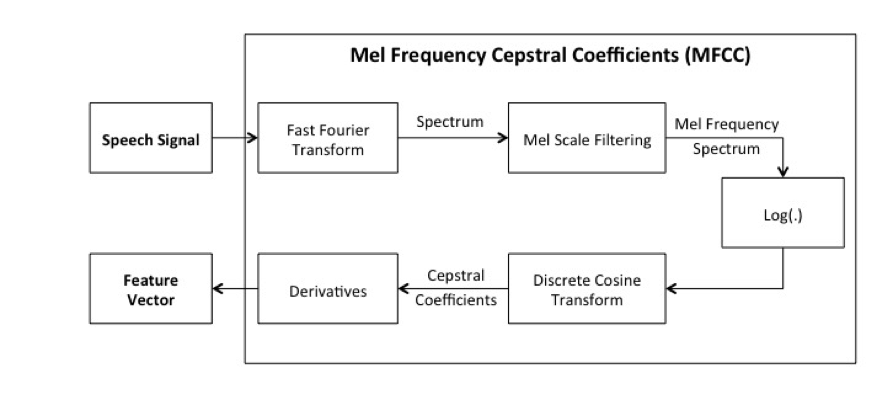

In [9]:
from IPython.display import Image
Image("images/MFCC_Flowchart.png")

## Resampled Sound<a id="resampl"></a> 
We now have an array of numbers with each number representing the sound wave’s amplitude at 1/16,000th of a second intervals.

We could feed these numbers right into a neural network. But trying to recognize speech patterns by processing these samples directly is difficult. Instead, we can make the problem easier by doing some pre-processing on the audio data.
<br>
Let’s start by grouping our sampled audio into 20-millisecond-long chunks. Here’s our first 20 milliseconds of audio (i.e., our first 400 samples):
Plotting those numbers as a simple line graph gives us a rough approximation of the original sound wave for that 20 millisecond period of time. This recording is only 1/50th of a second long. But even this short recording is a complex mish-mash of different frequencies of sound. There are some low frequency sounds, some mid-range sounds, and even some high-pitched sounds inside every sample. Taken all together, these different frequencies mix together to make up the complex sound of human speech.

To make this data easier for a neural network to process, we break apart this complex sound wave into it’s component parts. We select the low-pitched parts, the next-lowest-pitched-parts, and so on. By determining much energy is in each of those frequency bands (from low to high), we create a fingerprint for this audio snippet.

We do this using a mathematical operation called a <b>Fourier transform</b>. Fourier transform breaks apart the complex sound wave into the simple sound waves. Simple sound waves are simple periodic sines and cosines of different frequencies. Each individual sound wave, contains certain energy.

The energy of each simple sound wave is a score telling us how important each frequency range is, from low pitch (i.e. bass notes) to the highest pitch. Each number represents how much energy is in each 50hz band of our 20 millisecond audio clip. This is a lot easier to see when we draw this as a chart. If we repeat this process on every 20 millisecond chunk of audio, we end up with a spectrogram (each column from left-to-right is one 20ms chunk).

### Mel-Frequency Cepstrum Coefficients¶
Features we will extract from sound waves are Mel-Frequency Cepstrum Coefficients (MFCC)

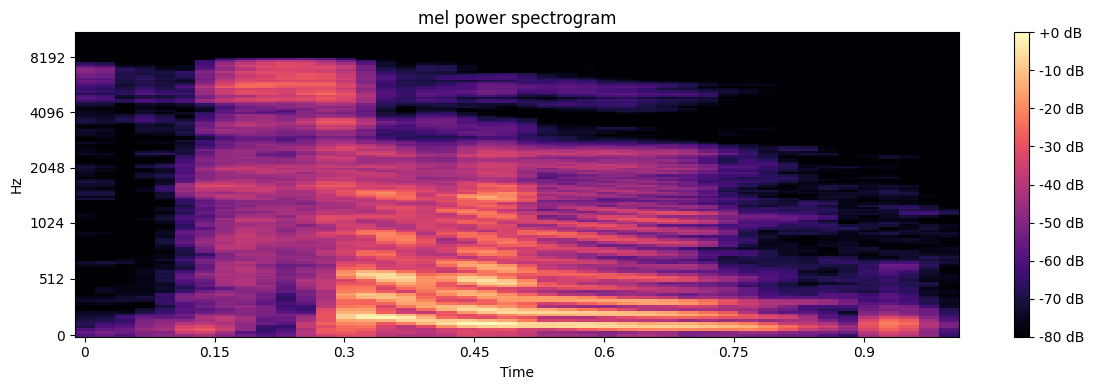

In [10]:
audio_path = './data/seven/6c968bd9_nohash_0.wav'
y, sr = librosa.load(audio_path)
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale along the y-axis
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

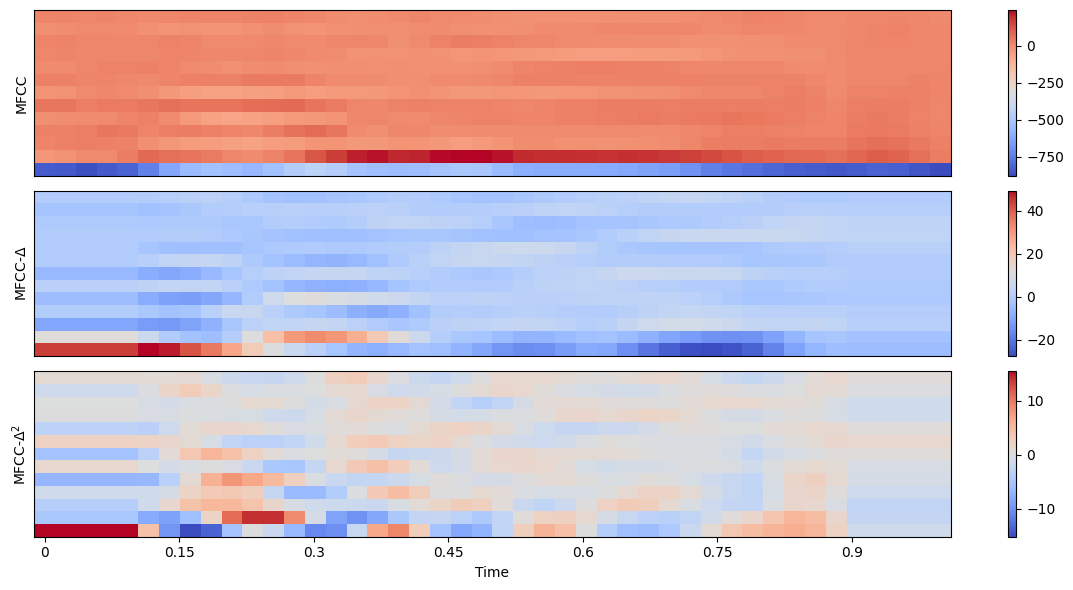

In [11]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# We will also display the first and second deltas 
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

In classical, but still important speach recognition systems, as well as in Deep Learning Speech Recognition systems, *MFCC*  are taken as the inputs to the speech recognition systems instead of spectrograms.

*MFCC* decorrelate features, while NNs deal with correlated features well. That is why, in some situations, we prefer not to use MFCCs, but rather use the raw spectrograms or mel power spectrograms. If we understand mel filters, we may consider their sensible usage.

## Silence removal
<a id="silenceremoval"></a> 

Let's listen to that `yes` file

In [12]:
ipd.Audio(samples, rate=sample_rate)

Although the words are short, there is a lot of silence in them. A decent VAD (Voice Activated Detection) could considerably reduce the size of the training dataset and accelerat training speed significantly. We will cut a bit of the file from the beginning and from the end and listen to it again (based on a plot above, we take samples from 3000 to 10000):

In [13]:
samples_cut = samples[3000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

The entire word is heard. It is impossible to cut all the files manually and do this based on the simple plot. For such file manipulation one can use for example *webrtcvad* package which has a good *VAD*.

A common exercise is to plot the spectrogram, together with presumed alignment of* 'y' 'e' 's'* graphems

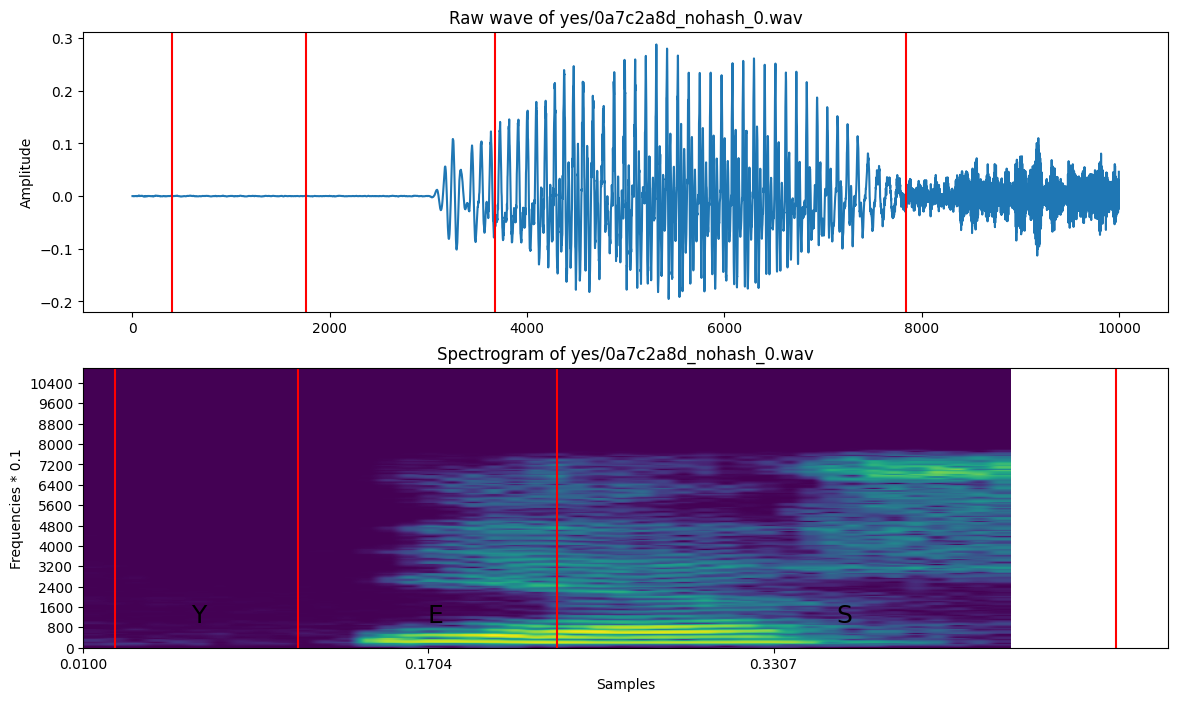

In [14]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

Please adjust boundaries of sounds for 'Y','E' and 'S' in the above code.

## Resampling - dimensionality reduction
<a id="resampl"></a> 

Another way to reduce the dimensionality of our data is to resample recordings.

Our recordings don't sound very natural, because they are sampled with 16k frequency. We usually hear a better speech. However, [the most speech related frequencies are presented in lower frequency band](https://en.wikipedia.org/wiki/Voice_frequency). You can understand another person talking over the telephone, where signal is sampled at 8000 Hz.

Summarizing, we could resample our dataset to 8k. That would discard some information that might or might not  be important, but we will reduce size of the data.

Resampling can be risky. Sometimes very small difference in sound matters. The benefit of resampling is that the initial experiments could be done faster with small datasets.

## Fast Fourier Transform (FFT)
We will use FFT (Fast Fourier Transform) to extract the frequency content of our speech recordings. Definition of a conveneince function `custom_fft()` follows:

In [15]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

Let's read some recording, resample it, and listen. We can also compare FFT-s. Notice, that there is almost no information above 4000 Hz in the original signal.

In [16]:
audio_path='./data'
filename = '/five/0b7ee1a0_nohash_0.wav'
new_sample_rate = 16000

samples, sample_rate = librosa.load(str(audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [17]:
ipd.Audio(samples, rate=sample_rate)

In [18]:
ipd.Audio(resampled, rate=new_sample_rate)

There is almost no difference!

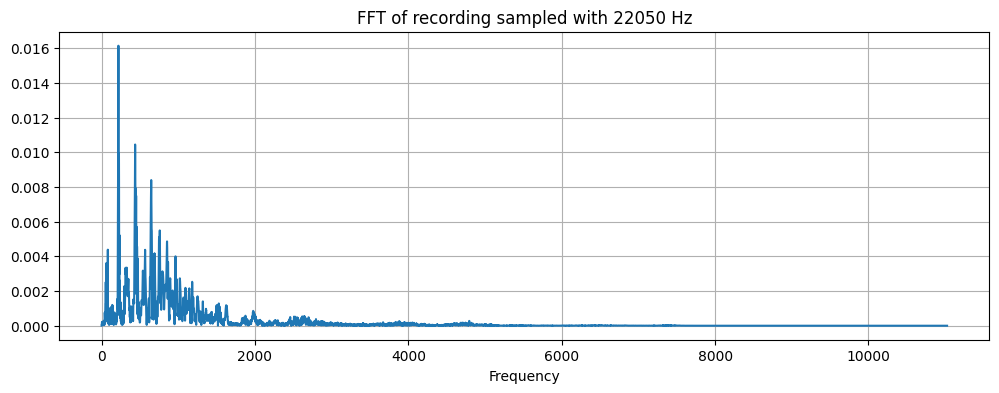

In [19]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

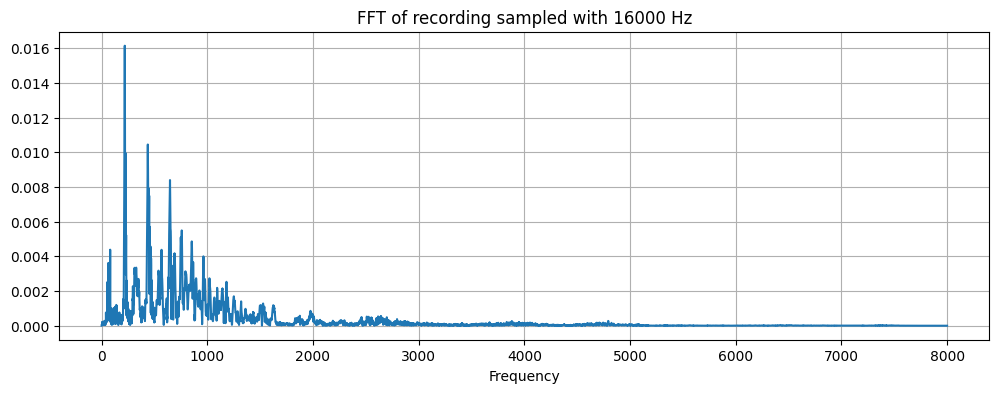

In [20]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

By resampling our wav files with twice lower frequency, we reduce the volume of Fourier image by 2.

## Features extraction steps
<a id="featuresextractionsteps"></a> 

We will use the following feature extraction algorithm :
1. Resample to reduce the volume of the data
2. Apply *VAD (Voice Activated Detection)* for elimination or padding of portion of files without speech.
3. Apply padding with 0 to make all signals have an equal length
4. Determine Log spectrogram (or *MFCC*, or *PLP*)
5. Features normalization with *mean* and *std*
6. Stacking of a given number of frames to get temporal information

*Perceptual Linear Prediction (PLP)*
Motivated by hearing perception, it uses equal loudness pre-emphasis and cube-root compression instead of the log compression. It also uses linear regressive to finalize the cepstral coefficients. PLP has slightly better accuracy and slightly better noise robustness.


## Dataset examination
<a id="investigations"></a> 

Before we proceed with extraction of features with need to perform standard investgation of the dataset.

### Identify the Number of Labels, Numbers of Samples under each label, etc.
<a id="numberoffiles"></a> 

In [21]:
audio_path= './data'
dirs = [f for f in os.listdir(audio_path) if isdir(join(audio_path,f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 6


### Histogram with number of samples in every class (label)

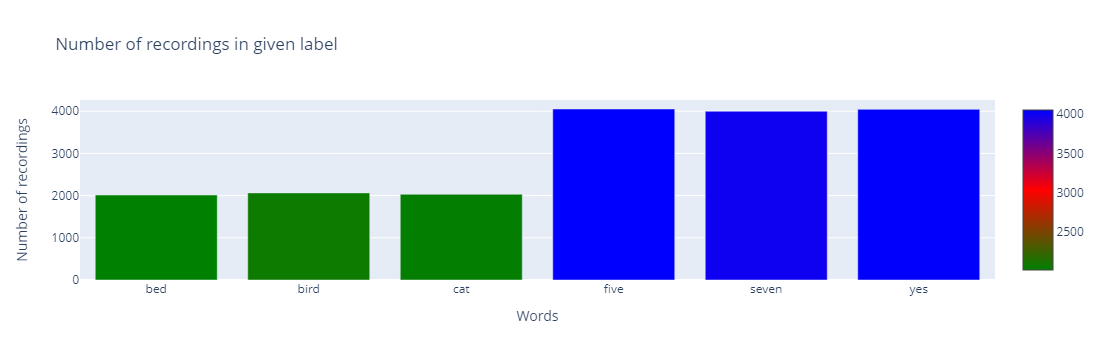

''

In [22]:
"""
HW Assignment"""
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale=[[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']], showscale=True
    ),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))
""""""

Dataset is not uniform but is balanced. There are no words (labels) with number of samples orders of magnitude smaller than in other classes.

### Deeper Analysis of the Recordings
Recordings come from very different sources. Some of them can come from mobile GSM (Global System for Mobile-Communiactions) channel.

*It is extremely important to split the dataset in a way that one speaker doesn't occur in both train and test sets.*

We will actually not perform such separation here. We do not have enough meta data and the spectral analysis for classiffication of sounds by speakers is longer than we can tolerate in this set of examples.

To see that there are repeated sampels coming from the same speaker, look and listen to this two examlpes:

seven/caf1803e_nohash_0.wav
./data/
./data/seven/caf1803e_nohash_0.wav


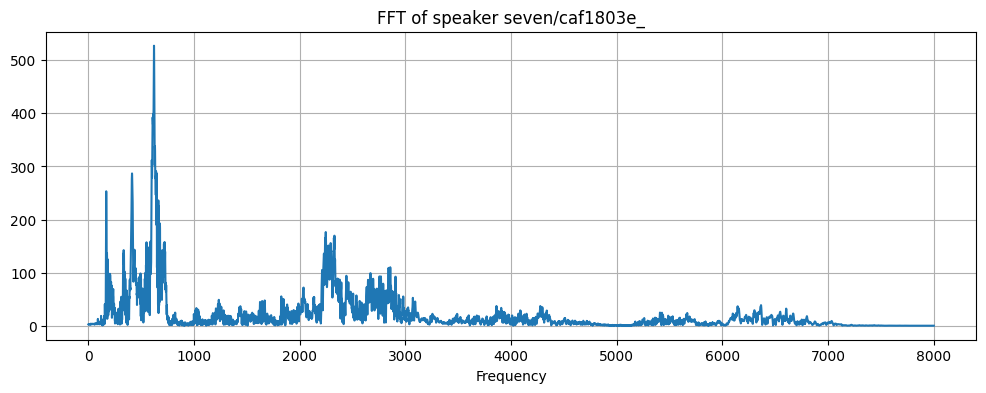

seven/0b77ee66_nohash_1.wav
./data/
./data/seven/0b77ee66_nohash_1.wav


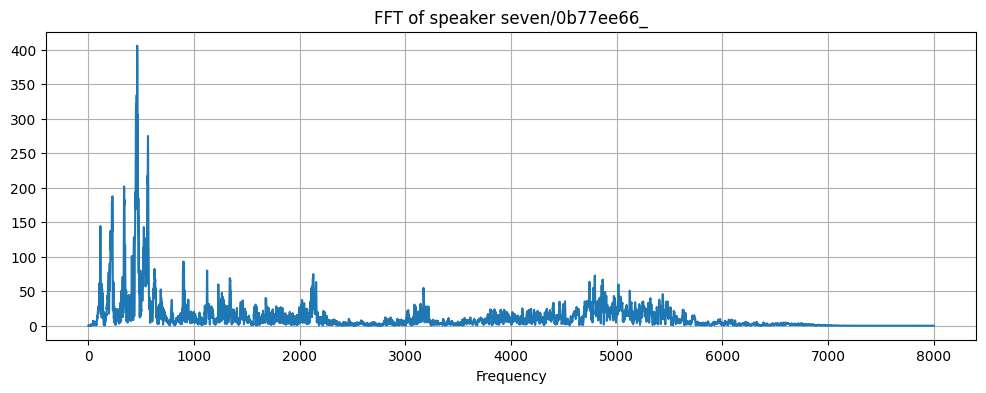

In [23]:
audio_path="./data/"
# filenames = ['/on/004ae714_nohash_1.wav','/on/0137b3f4_nohash_1.wav']
filenames = ['seven/caf1803e_nohash_0.wav','seven/0b77ee66_nohash_1.wav']
for filename in filenames:
    print(filename)
    print(audio_path)
    print(join(audio_path,filename))
    sample_rate, samples = wavfile.read(join(audio_path, filename))
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[0:15])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

It is even better to listen to the sound.

In [24]:
print('Speaker ' + filenames[0][0:15])
ipd.Audio(str(audio_path)+filenames[0])
ipd.Audio(samples, rate=sample_rate)

Speaker seven/caf1803e_


In [25]:
ipd.Audio(samples, rate=sample_rate)

The next one comes from a different speaker.

In [26]:
print('Speaker ' + filenames[0][0:15])
#ipd.Audio(join(train_audio_path, filenames[1]))
print('seven/d21fd169_nohash_1.wav')
ipd.Audio(join(audio_path, 'seven/d21fd169_nohash_1.wav'))

Speaker seven/caf1803e_
seven/d21fd169_nohash_1.wav


### Removal of Silence
There are also recordings with noticeable silence. Silence in captured recording is an oportunity for some compression?

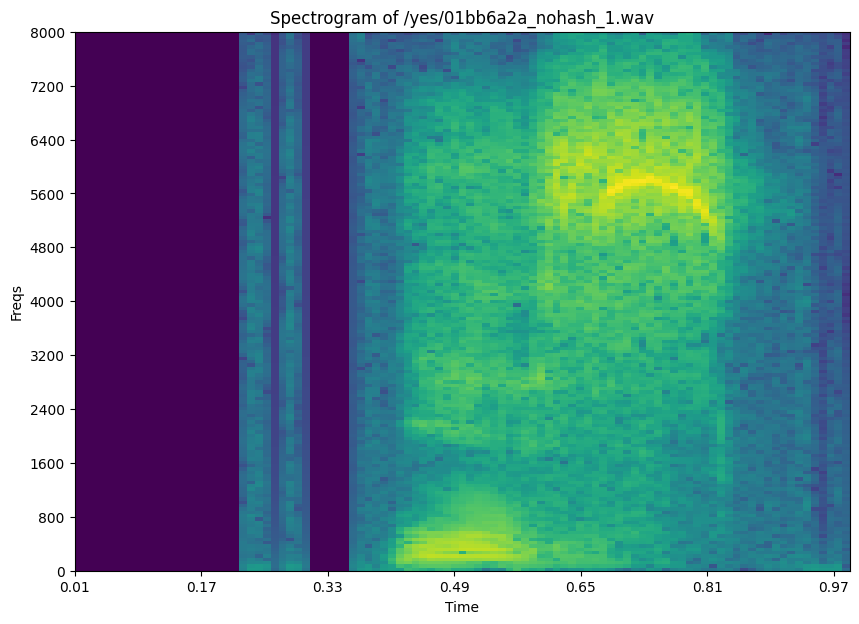

In [27]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

Dark blue regions represent silence, i.e. absence of useful signal.

### Determine lengths of recordings
<a id="len"></a> 

As an illustration we will find all the files that have 1 second duration:

In [28]:
print(dirs)
print(audio_path)

['bed', 'bird', 'cat', 'five', 'seven', 'yes']
./data/


In [29]:
num_of_shorter = 0
print(audio_path)
for direct in dirs:
    waves = [f for f in os.listdir(str(audio_path)+ direct) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(str(audio_path) +direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

./data/
Number of recordings shorter than 1 second: 1955


To bring those short files up to the standard length, we can pad them with zeros. Our DL networks usually prefer if we feed them inputs of a uniform size.

### Mean Spectrograms and FFT
<a id="meanspectrogramsandfft"></a> 
In some studies it is useful to examine the mean FFT for several words. We will plot such diagrams for select words: 'yes', 'bed', 'cat', 'five' & 'seven'

['bed', 'cat', 'five', 'seven', 'yes']


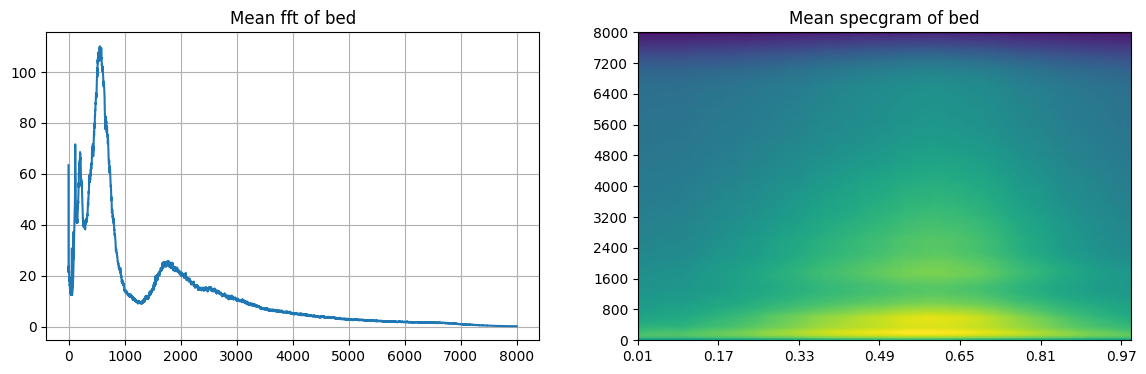

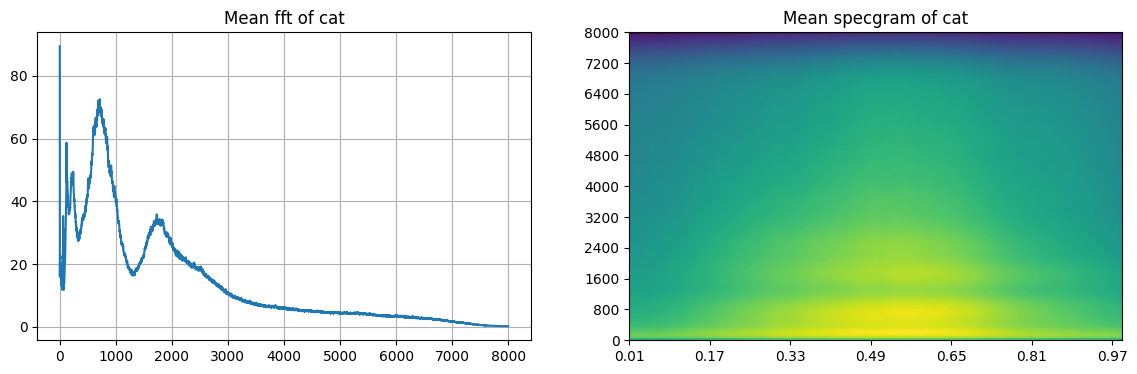

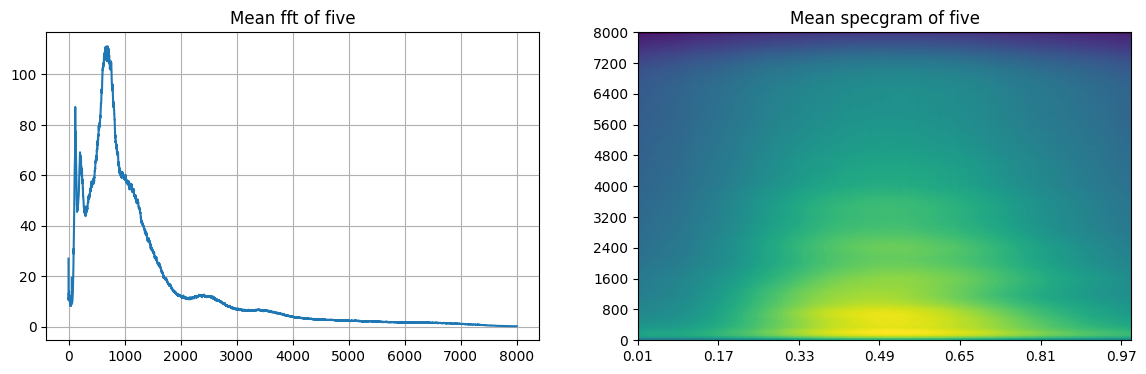

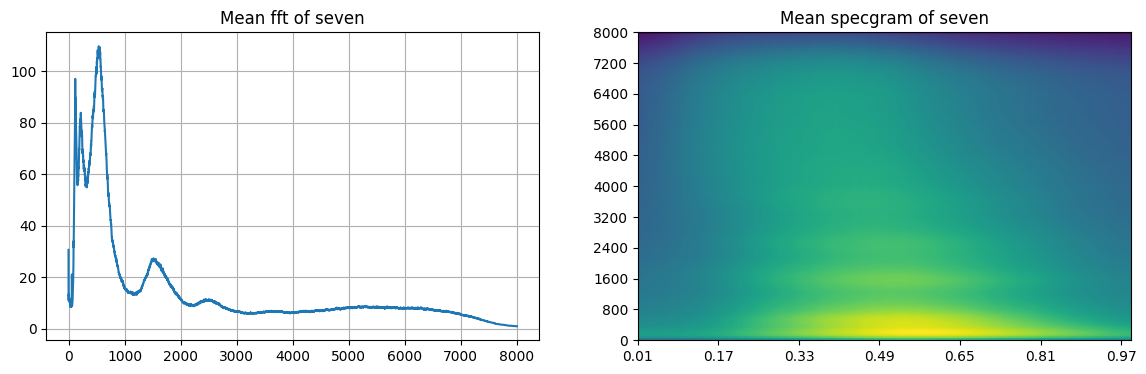

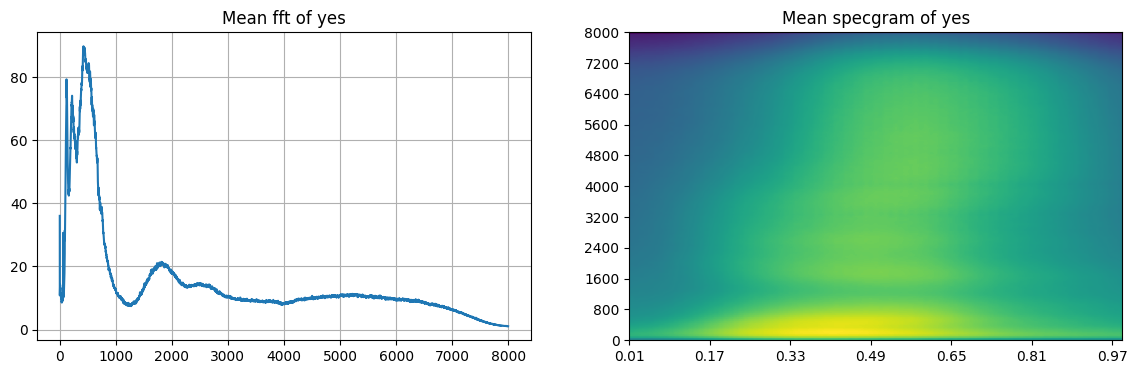

In [30]:
to_keep = 'yes bed cat five seven'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(audio_path + '/'+ direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

## Gaussian Mixtures modeling
<a id="gmms"></a> 

The mean FFTs look different for different words. We could model each FFT with a mixture of Gaussian distributions. Some of them however, look almost identical on FFT, like *cat* and *bed*. They are still distinguishable when we look at spectrograms! 

That's why temporal component of the spectrogram is also necessary. There is a [Kaldi](http://kaldi-asr.org/) library, that can model words (or smaller parts of words) with GMMs and model temporal dependencies with [Hidden Markov Models](https://github.com/danijel3/ASRDemos/blob/master/notebooks/HMM_FST.ipynb).

We could use simple GMMs for words to check what can we model and how hard it is to distinguish words one from the other. We can use [Scikit-learn](http://scikit-learn.org/) for that, however it is not straightforward and the calculations are very long, so I abandon this idea for now.

## Frequency components across the words
<a id="components"></a> 
One popular type of plots that depicts the frequency content of different words is called violin plot.

In [31]:
def violinplot_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(audio_path, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                audio_path +'/'+ direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprec

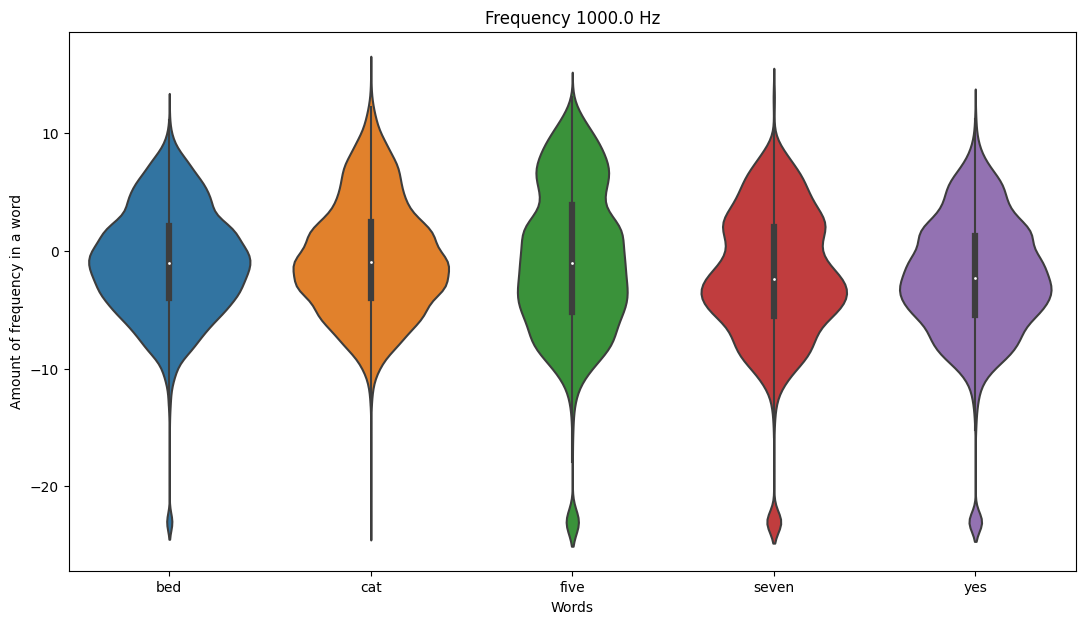

In [32]:
violinplot_frequency(dirs, 20)

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprec

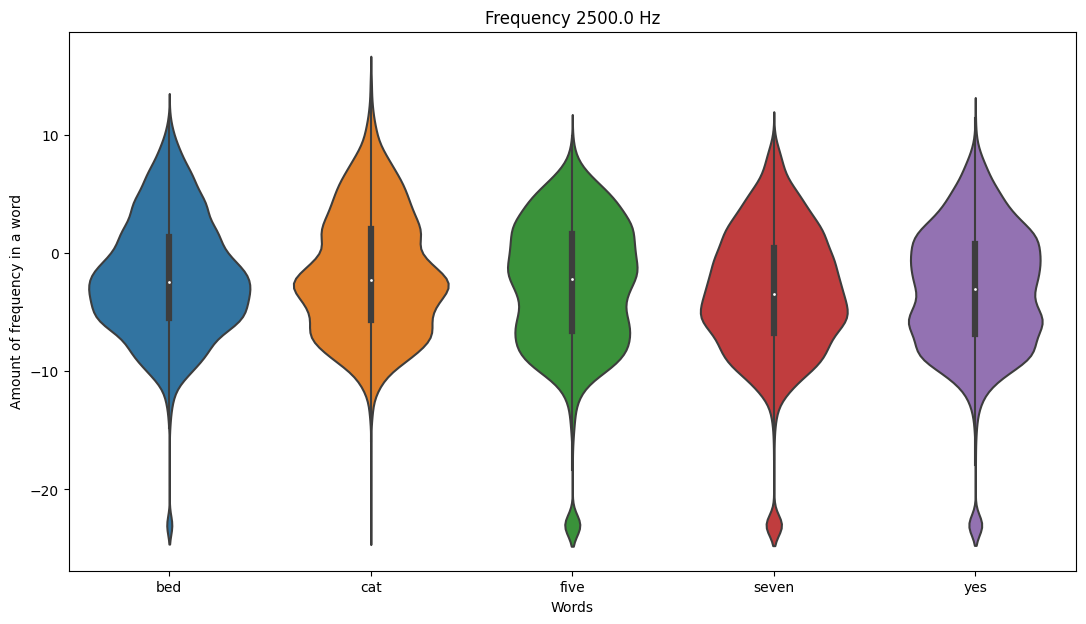

In [33]:
violinplot_frequency(dirs, 50)

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprec

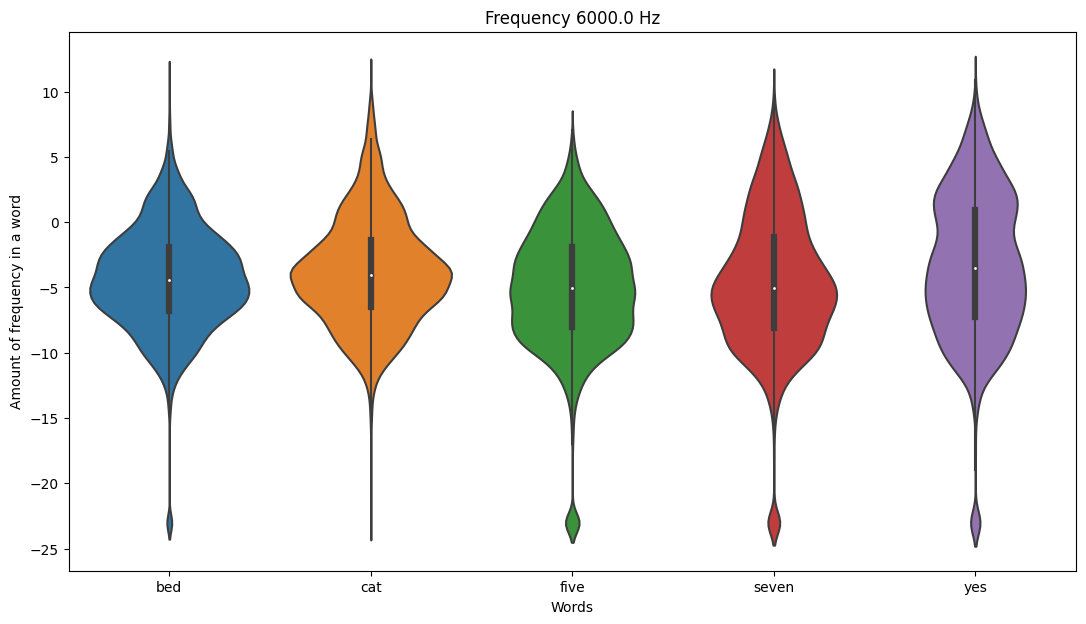

In [34]:
violinplot_frequency(dirs, 120)

### Anomaly detection

We should check if there are any recordings that somehow stand out from the rest. We can project our entire dataset to a space of lower dimensionality (2 or 3) and interactively check for any anomaly. We will use PCA for dimensionality reduction.

Please note that the following cell takes long time to run. To reduce run time, we reduced the number of words in `./data` directory to six: `bed`, `bird`, `cat`, `five`, `happy` and `seven`


Before starting the following two cells, remove directories and files that do not correspond to the regular words. They cause erorros.

In [35]:
audio_path= './data'
dirs = [f for f in os.listdir(audio_path) if isdir(join(audio_path,f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 6


C:\Users\Zoran\.conda\envs\tf-gpu\lib\site-packages\plotly\graph_objs\_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




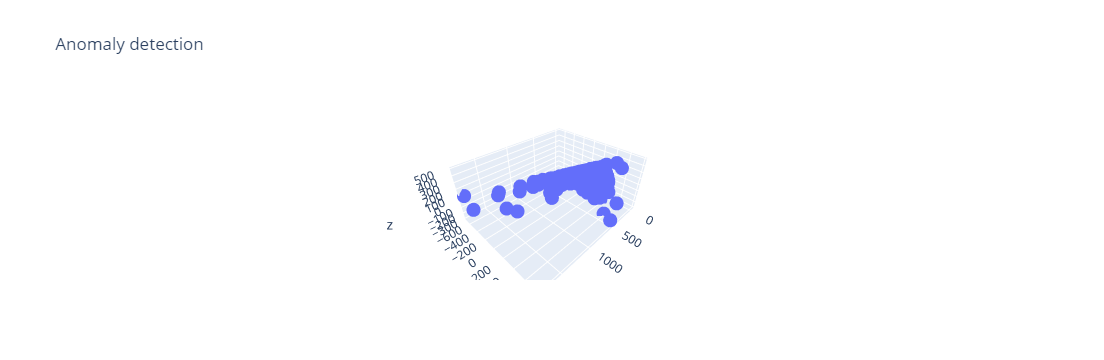

In [36]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(str(audio_path) +'/'+ direct) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(audio_path +'/'+ direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    #data = go.Scatter([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)

In [37]:
audio_path='./data'

Please notice that you can rotate the above 3-d plot and expose outliers in different portions of this projection space.
Notice that there are points represneting `yes/e4b02540_nohash_0.wav`, `bed/9aa21fa9_nohash_0.wav`, `seven/b1114e4f_nohash_0.wav` and recordings that lie far away from the rest. Those are the outliers or anomalies.

Listen to those outliers. Some of them sound quite unusual. For others it is hard to tell what is "wrong" with them.

In [38]:
print('Recording yes/e4b02540_nohash_0.wav')
ipd.Audio(join(audio_path +'/'+ 'yes/e4b02540_nohash_0.wav'))

Recording yes/e4b02540_nohash_0.wav


If you are looking for anomalies for individual words, you could, for example, find this file for word seven:

In [39]:
print('Recording seven/b1114e4f_nohash_0.wav')
ipd.Audio(audio_path +'/'+ 'seven/b1114e4f_nohash_0.wav')

Recording seven/b1114e4f_nohash_0.wav


The first two sample contained nothing obviously unusual. The second sample did sound weird. Usually, you can find some distortions using this method.

##  Where to look for the inspiration
<a id="wheretostart"></a> 

<b>Speech recognition is a really big R&amp;D field and it is hard to get to know important things in short time!</b>

You can take many different approaches for solutions based on neural networks and architectures. Connectionist Temporal Classification (CTC) by using Recurrent Neural Network (RNN) in TensorFlow, Keras, Automatic Speech Recognition (ASR), Hidden Markov Model (HMM) based on ASR, Gaussian mixture models with HMMs, Deep models with HMMs, Large Vocabulary Continuous Speech Recognition Systems (LVCSR).

This tutorial focuses on two models and a very small vocabulary, with recordings with only one word in it, with a (mostly) given length:

1. Encoder-decoder: https://arxiv.org/abs/1508.01211
2. RNNs with CTC loss: https://arxiv.org/abs/1412.5567<br>

3. Classic speech recognition is described here: http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf

You can find *Kaldi* [Tutorial for dummies](http://kaldi-asr.org/doc/kaldi_for_dummies.html), with a problem similar to this competition in some way.

Notebook code was adapted from the follwing sources:<br>
Tensorflow:<br>
https://www.tensorflow.org/tutorials/audio_recognition
https://github.com/ugnelis/tensorflow-rnn-ctc/blob/master/README.md
<br>
LibROSA:https://github.com/librosa/librosa/tree/main/docs/examples <br>
Kaggle / Data / Python code: <br>
https://github.com/pannous/tensorflow-speech-recognition
https://www.kaggle.com/davids1992/speech-representation-and-data-exploration/notebook
https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/download/train.7z
https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/download/test.7z